# Process Gene Expression from DataDescriptor
This notebook will prepare gene expression information from [Nature Scientific Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5903355/pdf/sdata201861.pdf).
The data is already quantified (FPKM) and contains normal and tumor tissue samples.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [2]:
tissue_pairs = [('bladder', 'blca'), ('breast', 'brca')]

def compute_geneexpression_foldchange(tumor_path, normal_path):
    tumor_ge = pd.read_csv(tumor_path, compression='gzip')
for gtex_tissue, tcga_project in tissue_pairs:
    tumor_tissue = pd.read_csv()

TypeError: parser_f() missing 1 required positional argument: 'filepath_or_buffer'

In [3]:
def compute_geneexpression_foldchange(tumor_path, normal_path):
    # read tumor and normal data
    tumor_ge = pd.read_csv(tumor_path, compression='gzip', sep='\t').set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
    normal_ge = pd.read_csv(normal_path, compression='gzip', sep='\t').set_index('Hugo_Symbol').drop('Entrez_Gene_Id', axis=1)
    assert (np.all(tumor_ge.index == normal_ge.index))

    # compute log2 fold changes
    fc = np.log2(tumor_ge.divide(normal_ge.mean(axis=1), axis=0))
    fc = fc.replace([np.inf, -np.inf], np.nan).dropna(axis=0) # remove NaN and inf (from division by 0 or 0+eta)
    return fc.mean(axis=1), tumor_ge, normal_ge 

brca_foldchanges, brca_tcga, breast_gtex = compute_geneexpression_foldchange('../../data/pancancer/TCGA/expression/tcga_geneexpression_datadescriptor/brca-rsem-fpkm-tcga-t.txt.gz', 
                                                     '../../data/pancancer/TCGA/expression/tcga_geneexpression_datadescriptor/breast-rsem-fpkm-gtex.txt.gz')

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log2


(982, 1) (89, 1)


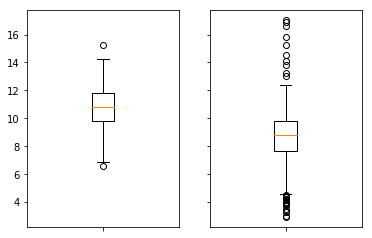

In [11]:
gene_name = 'IGF2'
col1 = np.log2(brca_tcga[brca_tcga.index == gene_name].T)
col2 = np.log2(breast_gtex[breast_gtex.index == gene_name].T)
print (col1.shape, col2.shape)
ax1 = plt.subplot(1, 2, 1)
_ = plt.boxplot(col2.T)
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
_ = plt.boxplot(col1.T)
_ = plt.setp(ax1.get_xticklabels(), visible=False)
_ = plt.setp(ax2.get_xticklabels(), visible=False)
_ = plt.setp(ax2.get_yticklabels(), visible=False)

In [13]:
brca_foldchanges[brca_foldchanges.index == 'BRCA2']

Hugo_Symbol
BRCA2    0.905673
dtype: float64

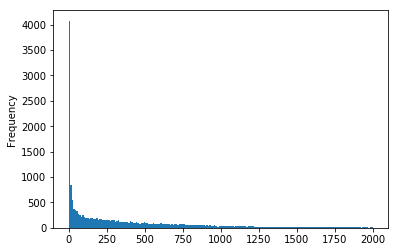

In [128]:
breast_gtex.plot(kind='hist', bins=np.linspace(0, 2000, 200))

In [20]:
onco_tsgs = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t')
brca_fc = pd.DataFrame(brca_foldchanges)
brca_fc['Cancer_Gene'] = False
brca_foldchanges.loc[brca_foldchanges.index.isin(onco_tsgs['Gene Symbol']), 'Cancer_Gene'] = True

IndexingError: (array([False, False, False, ..., False, False, False]), 'Cancer_Gene')

In [21]:
brca_foldchanges

Hugo_Symbol
KIF1C         -0.995399
SWAP70        -0.883106
PAK1           0.359945
PLEKHM3       -1.968879
MCFD2         -0.610910
RBM12         -0.093111
PSMD12         0.356487
SLC7A11        0.721915
BTN3A1        -0.802290
LPIN1         -1.761111
L3MBTL2        0.010955
SLC9A9        -1.881686
ST7L          -0.314090
CACNA2D4      -0.542826
ZNF84         -0.330538
HLA-DQB1      -0.038286
DPP4          -2.517309
ATP5D         -0.067435
LAMB3         -3.096960
MRPL34         0.054406
C19orf57      -0.235387
BNIP3L        -0.997854
NT5DC2        -0.120609
TSFM           0.377750
DDR1           0.656781
MEIS3          0.195947
KIF1B         -0.850619
PMEPA1        -0.110106
MARVELD3       0.805785
RGPD8         -1.541281
                 ...   
TMEM5         -0.189943
NPDC1         -0.252753
CCM2          -0.131899
NDOR1          0.443882
TLCD1          1.613185
STX7          -0.836367
METTL5        -0.263510
FJX1           0.010619
FGF7          -2.929063
RBM10          0.216502
PNPT